
# Telco Customer Churn Prediction

Churn prediction is a critical aspect for businesses, especially in the subscription-based sector, to retain their customers and enhance profitability. In this notebook, we will be analyzing a dataset of telco customers and developing a predictive model to understand the key factors that influence customer churn. 

## Objectives
- Perform exploratory data analysis (EDA) to understand the data distribution and key characteristics.
- Preprocess the data including feature selection, transformation, and scaling.
- Train several machine learning models and select the one with the best performance.
- Interpret the results to understand the most important features driving churn.



# Step 1: Importing Essential Libraries

In this step, we import the essential libraries required for data manipulation, visualization, and model building.


In [1]:
# Importing Essential Libraries
# Import the core libraries for data manipulation (pandas), numerical computation (numpy), 
# and visualization (matplotlib, seaborn) that we will need for EDA and model building.
# Import others libraries for processing and moduling 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.cluster import KMeans
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, ConfusionMatrixDisplay, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import RandomizedSearchCV
import joblib


# Setting global plot style for consistency
sns.set(style="whitegrid")


# Step 2: Data Loading and Initial Exploration

Here, we load the Telco Customer Churn dataset and conduct initial exploration to understand the data types, number of columns, and any missing values.


In [2]:
# Data Loading
# Loading the dataset into a pandas DataFrame to start our data analysis and model building.
data = pd.read_excel("Telco_customer_churn.xlsx")

# Basic Data Exploration
# Let's explore the structure of our dataset to understand the types of features available.
data.info()  # Displays information about columns and data types

# Checking for missing values
print("Missing values per column:")
print(data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

Here are some quick comments for the Data Loading and Initial Exploration step:

1. **Dataset Size**: The dataset contains 7,043 entries across 33 columns. This is a moderately sized dataset suitable for typical machine learning models.

2. **Data Types**: The dataset has mixed data types, including numerical (`int64`, `float64`) and categorical (`object`). Some columns like `Total Charges` are of type `object` and might need conversion for numerical analysis.

3. **Non-Null Counts**: Most columns have no missing values, except for `Churn Reason`, which has a large number of missing entries (5,174 out of 7,043). We need to decide how to handle this column—either by imputing, dropping, or analyzing its impact.

4. **Unique Identifiers**: Columns like `CustomerID` are unique identifiers and should be dropped for modeling purposes as they do not contribute to predicting churn.

5. **Redundant Columns**: Some columns such as `Count`, `Lat Long`, `Zip Code`, and `Churn Score` may not provide additional predictive power and could be dropped during data cleaning.

These observations will help guide the feature selection and preprocessing steps.

# Step 3: Data Cleaning and Preprocessing
In this section, we will clean the dataset by handling missing values, dropping unnecessary features, and encoding categorical variables.

In [3]:
# Identify Categorical Columns
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
print(f"Categorical Columns: {numerical_cols}")

print("\n-------numerical Values---------")
for col in numerical_cols:
    print(f"{col}: {data[col].unique()}")

Categorical Columns: Index(['Count', 'Zip Code', 'Latitude', 'Longitude', 'Tenure Months',
       'Monthly Charges', 'Churn Value', 'Churn Score', 'CLTV'],
      dtype='object')

-------numerical Values---------
Count: [1]
Zip Code: [90003 90005 90006 ... 96128 96134 96146]
Latitude: [33.964131 34.059281 34.048013 ... 40.346634 41.813521 39.191797]
Longitude: [-118.272783 -118.30742  -118.293953 ... -120.386422 -121.492666
 -120.212401]
Tenure Months: [ 2  8 28 49 10  1 47 17  5 34 11 15 18  9  7 12 25 68 55 37  3 27 20  4
 58 53 13  6 19 59 16 52 24 32 38 54 43 63 21 69 22 61 60 48 40 23 39 35
 56 65 33 30 45 46 62 70 50 44 71 26 14 41 66 64 29 42 67 51 31 57 36 72
  0]
Monthly Charges: [ 53.85  70.7   99.65 ... 108.35  63.1   78.7 ]
Churn Value: [1 0]
Churn Score: [ 86  67  84  89  78 100  92  77  97  74  66  65  70  90  82  69  81  96
  87  88  75  76  95  99  80  73  94  83  98  71  85  68  91  93  72  79
  27  61  43  51  58  39  35  57  53  21  38  40  41  22  25  64  49  62
  52

I will drop ((Count)) variable, because it is has unique value and it does not contain any pattern or relationship with the target variable.

In [4]:
data.drop('Count',axis=1, inplace=True)

I will CLTV (drop Customer Lifetime Value) variable because it is already a prediction based on many variables known to affect churn, including it in your machine learning model introduces target leakage.

In [5]:
data.drop('CLTV',axis=1, inplace=True)

C:\Users\musta\AppData\Local\Temp\ipykernel_9532\1660889731.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


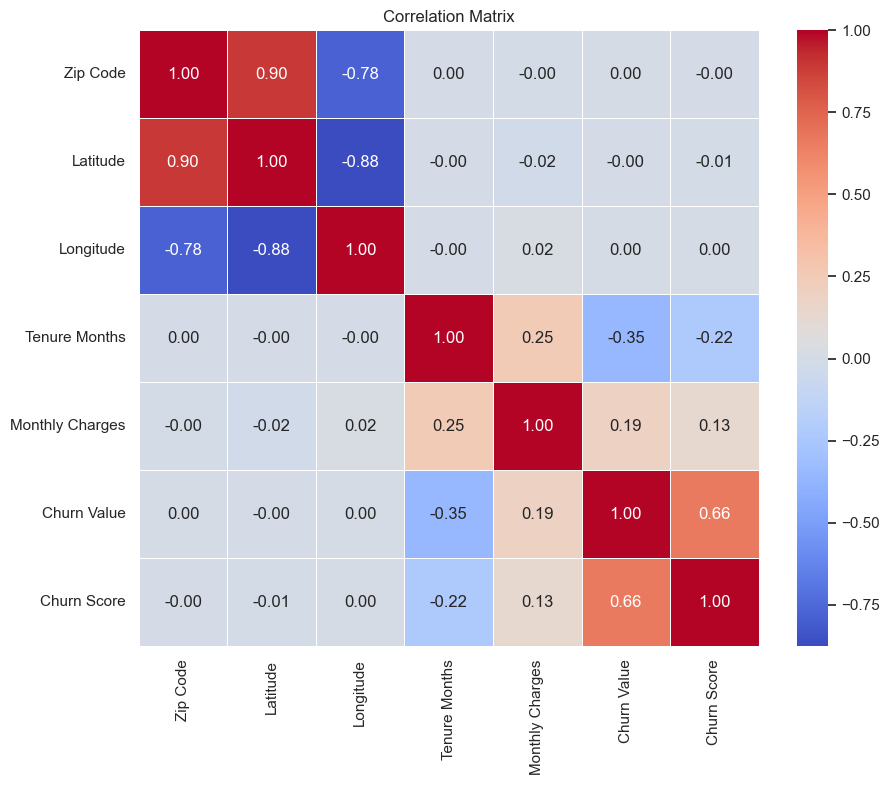

In [6]:
# Compute the correlation matrix for numerical features
correlation_matrix = data.corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

#### Key Observations from the Correlation Matrix:
- The Tenure Months is correlated negatively with the target about - 0.35, that indicates the cunstumers  with longer tenure are less likely to churn.
- Monthly Charge is weak corrected positively with the target about 0.19, that indictes the cunstumers with Higher monthly charges slightly increase the likelihood of churn.
- CLTV (Customer Lifetime Value) is  weak corrected negatively with the target about -0.13,that indictes the cunstumers with higher CLTV customers are slightly less likely to churn.
- Churn Score is strong corrected positively with the target about 0.66, however, this is a data leakage risk if Churn Score is derived from or influenced by churn data.
- Zip Code, Latitude, and Longitude:
 -- Zip Code & Latitude: 0.90
 -- Latitude & Longitude: -0.88
 --These high correlations indicate these geographical features are redundant.


I will drop ((Churn Score)) variable because it is already a prediction based on many variables known to affect churn, including it in your machine learning model introduces target leakage.

In [7]:
data.drop('Churn Score', axis=1, inplace=True)

I will drop ip Code, Latitude, and Longitud because they are a redundant atures and are not directly predictive of churn (correlation with Churn Value is close to 0).

In [8]:
data_city = data[['Latitude', 'Longitude']] #I will save this dataset to use it for creation the Feature Engineering for City.
data.drop(['Zip Code', 'Latitude', 'Longitude'], axis=1, inplace=True)

In [9]:
# Identify columns with only one unique value
single_value_cols = [col for col in data.columns if data[col].nunique() == 1]

# Print the columns with a single unique value
print(f"Columns with a single unique value: {single_value_cols}")

Columns with a single unique value: ['Country', 'State']


I have to drop these variables: ((Count, Country, State)) because they have only one unique value across all rows.
This columns don't add any useful information to the model because they have no variability. they are essentially constant 
for all data points and will not help differentiate between target outcomes.

I will drop ((CustomerID)), because it is an Unique Identifiers and it does not contain any pattern or relationship with the target variable.

In [10]:
# Drop these columns from the dataset
data.drop(single_value_cols, axis=1, inplace=True)
data.drop('CustomerID', axis=1,inplace=True)

In [11]:
# Identify columns with a binary types (type of categorical) and tronsform them to numerical 0 and 1
binary_values_cols_catg = [col for col in data.columns if data[col].nunique() == 2 and data[col].dtype == 'object']
# Print the columns with a binary values
print(f"-- Columns with a binary values: {binary_values_cols_catg}")

print("\n-------Binary Values---------")
for col in binary_values_cols_catg:
    print(f"{col}: {data[col].unique()}")

-- Columns with a binary values: ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Paperless Billing', 'Churn Label']

-------Binary Values---------
Gender: ['Male' 'Female']
Senior Citizen: ['No' 'Yes']
Partner: ['No' 'Yes']
Dependents: ['No' 'Yes']
Phone Service: ['Yes' 'No']
Paperless Billing: ['Yes' 'No']
Churn Label: ['Yes' 'No']



# Step 4: Feature Engineering

We perform feature engineering by encoding categorical variables. Binary features are transformed into numeric values, and one-hot encoding is used for multi-category features.


In [12]:
# Encoding categorical variables into numerical representations is essential for most machine learning algorithms.
# Binary features are mapped to 0 and 1 for simplicity.

for col in ['Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Paperless Billing']:
    data[col] = data[col].map({'Yes': 1, 'No': 0})

# Encoding 'Gender' into a binary feature: 1 for Male, 0 for Female
data['Gender'] = data['Gender'].map({'Male': 1, 'Female': 0})

# One-Hot Encoding for multi-category features such as Internet Service, Contract, and Payment Method
data = pd.get_dummies(data, columns=['Internet Service', 'Contract', 'Payment Method'], drop_first=True)
#I will drop Churn Label because it is the same of Churn value and it is our target
data.drop('Churn Label', axis=1,inplace=True)

In [13]:
categorical_cols = data.select_dtypes(include=['object', 'category']).columns
print(f"Categorical Columns: {categorical_cols}")

print("\n-------categorical Values---------")
for col in categorical_cols:
    print(f"{col}: {data[col].nunique()}")

Categorical Columns: Index(['City', 'Lat Long', 'Multiple Lines', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Total Charges', 'Churn Reason'],
      dtype='object')

-------categorical Values---------
City: 1129
Lat Long: 1652
Multiple Lines: 3
Online Security: 3
Online Backup: 3
Device Protection: 3
Tech Support: 3
Streaming TV: 3
Streaming Movies: 3
Total Charges: 6531
Churn Reason: 20


# Step 5: Feature Exploration and Cleaning base for further processing
In this section, we will visualize some of the key features to understand their relationship with the target variable (Churn Value).

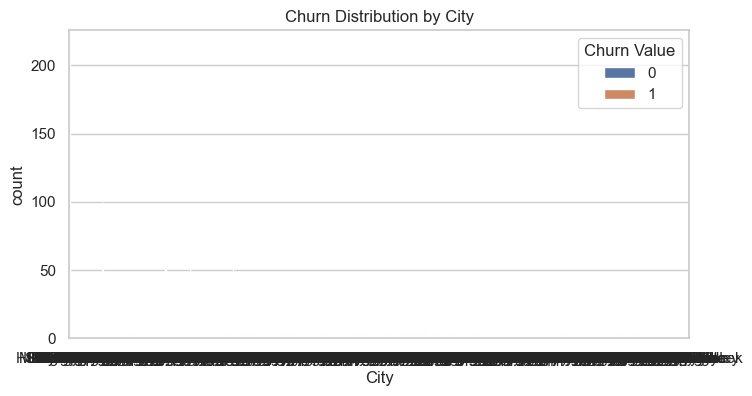

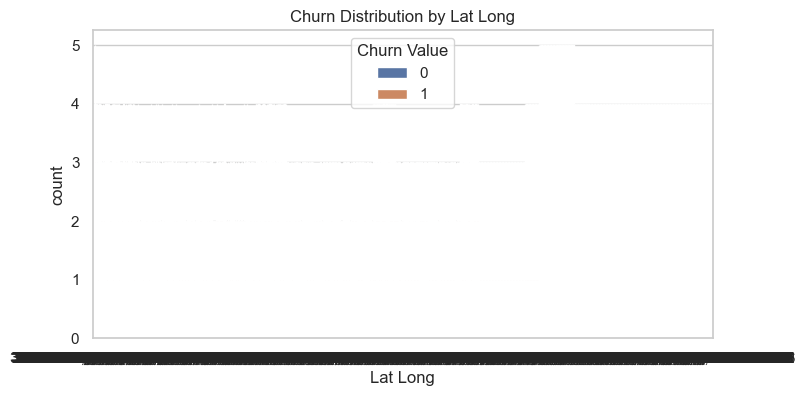

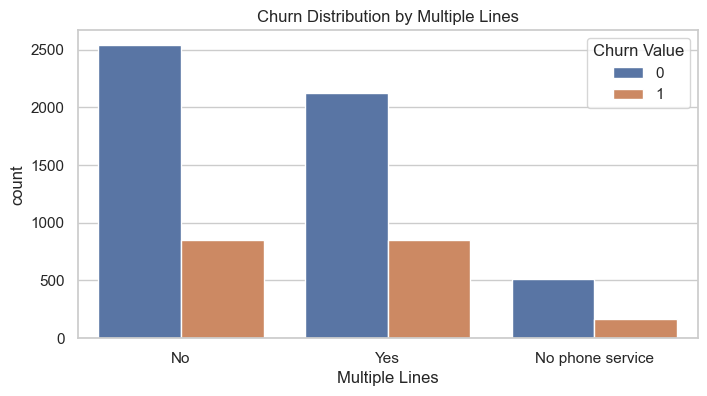

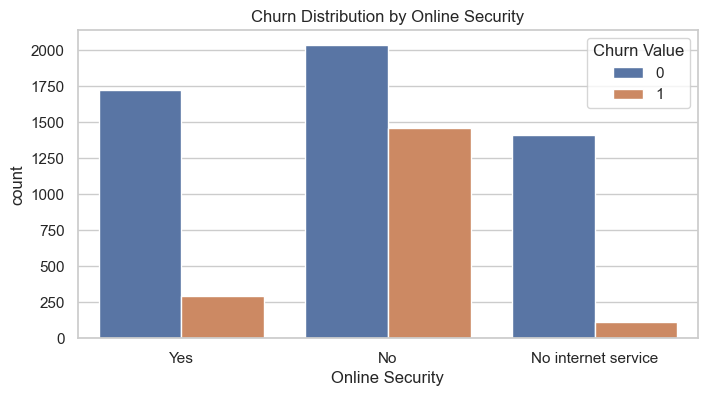

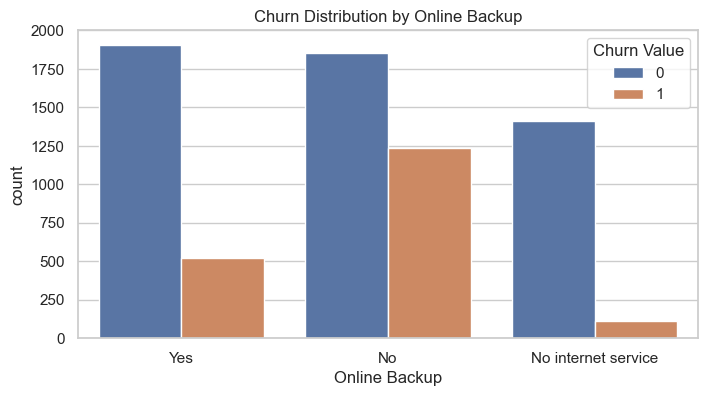

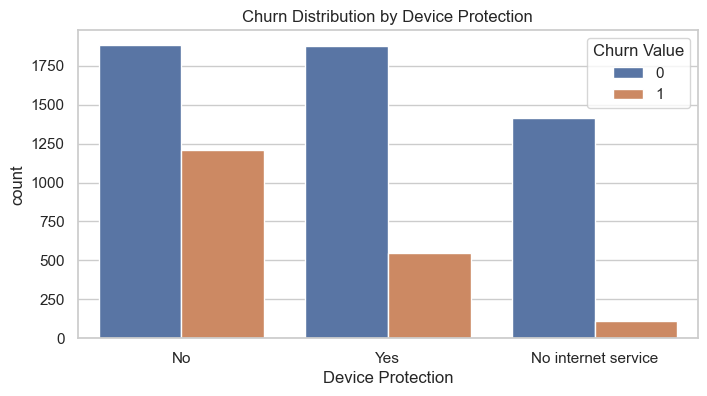

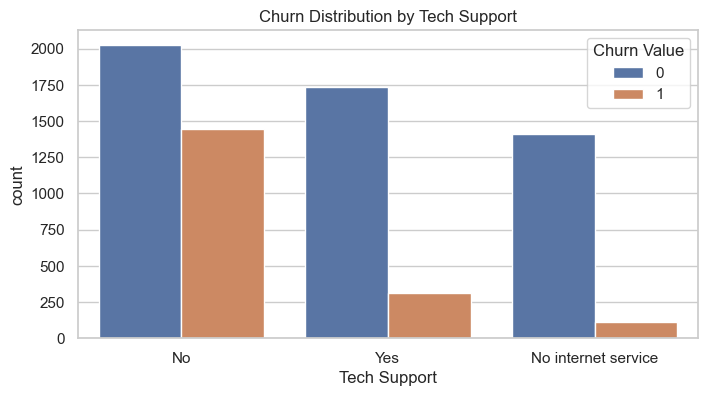

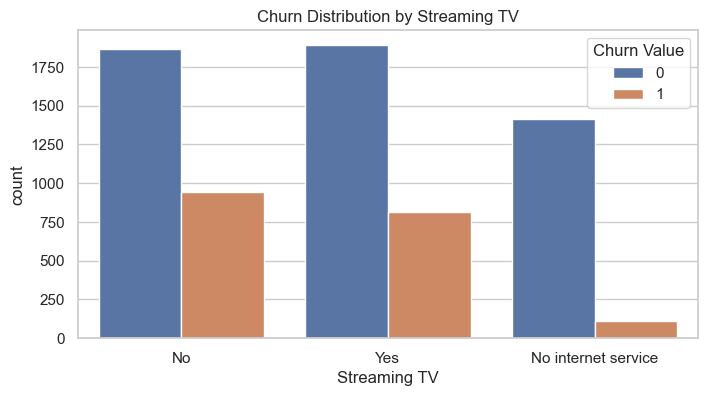

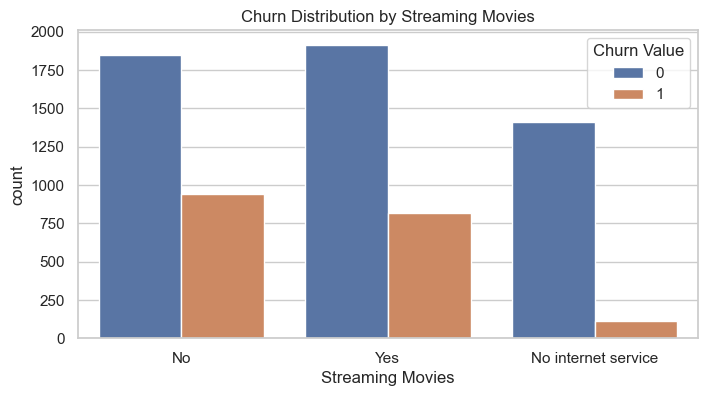

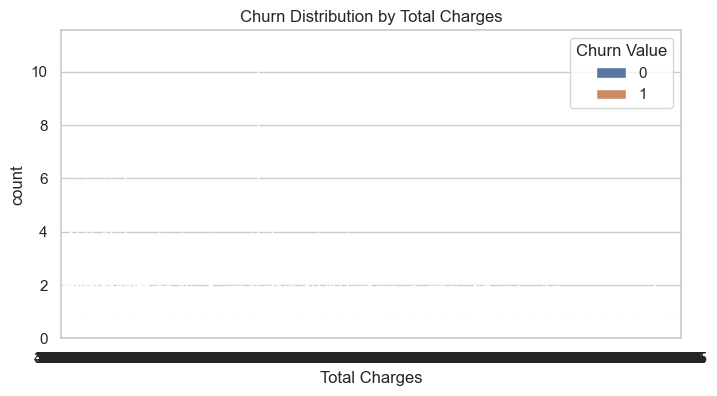

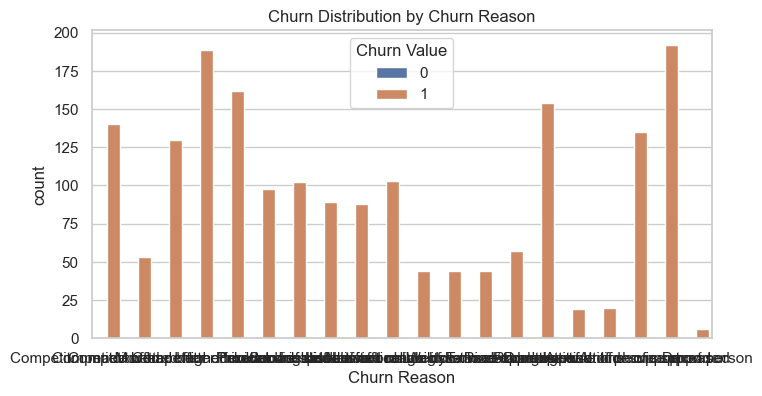

In [14]:
# Plot each categorical feature against Churn Value
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, hue='Churn Value', data=data)
    plt.title(f'Churn Distribution by {col}')
    plt.show()

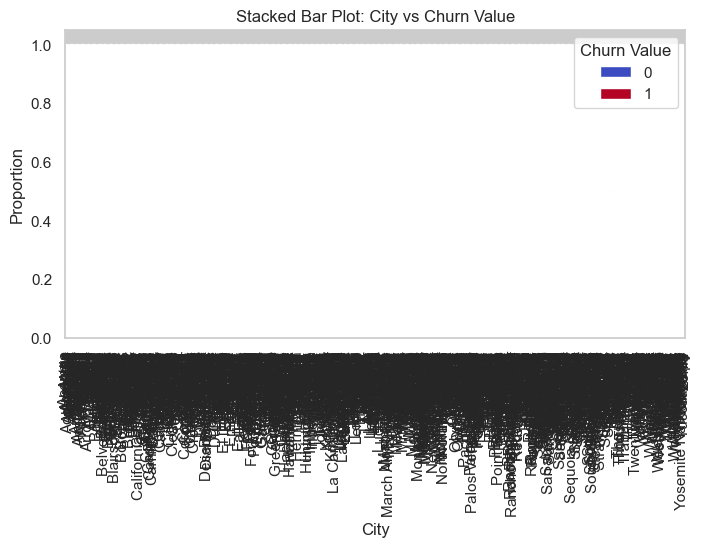

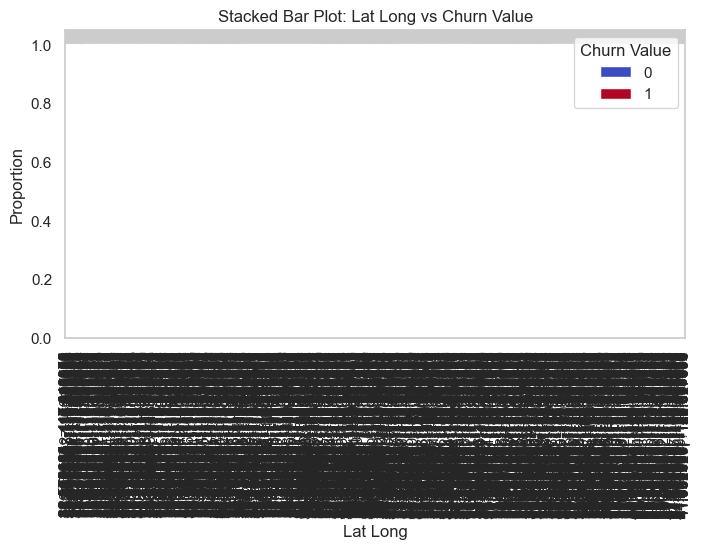

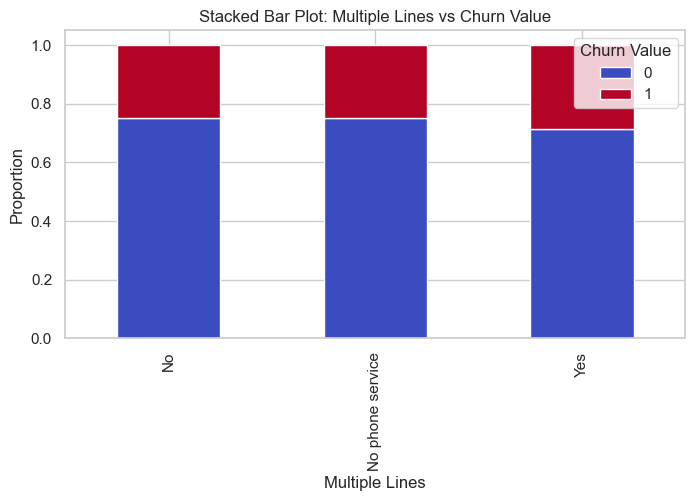

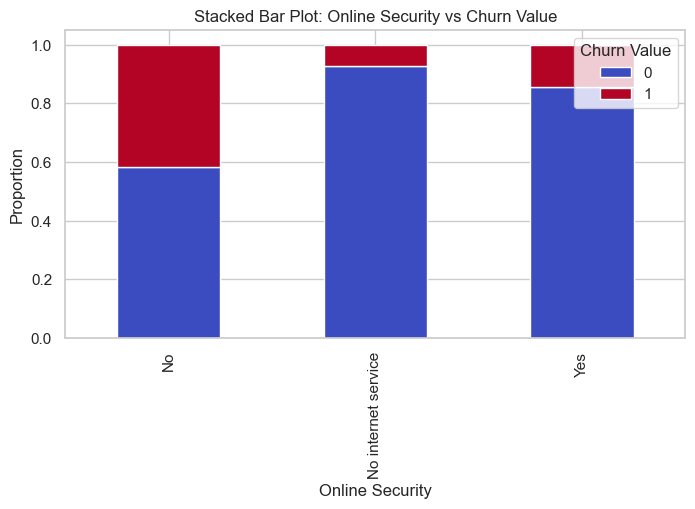

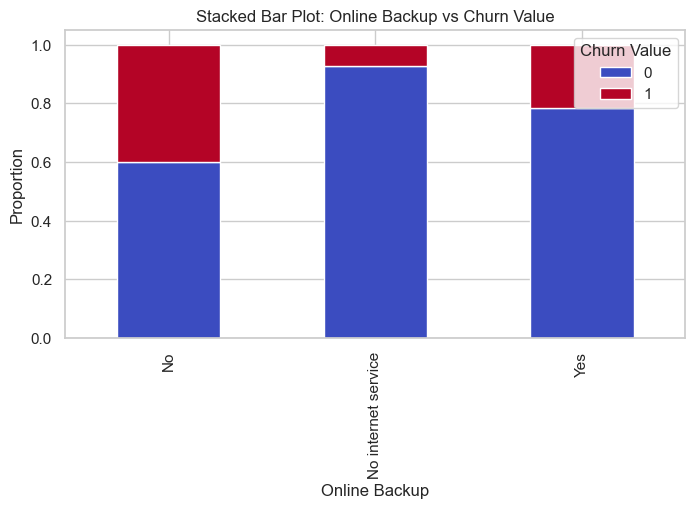

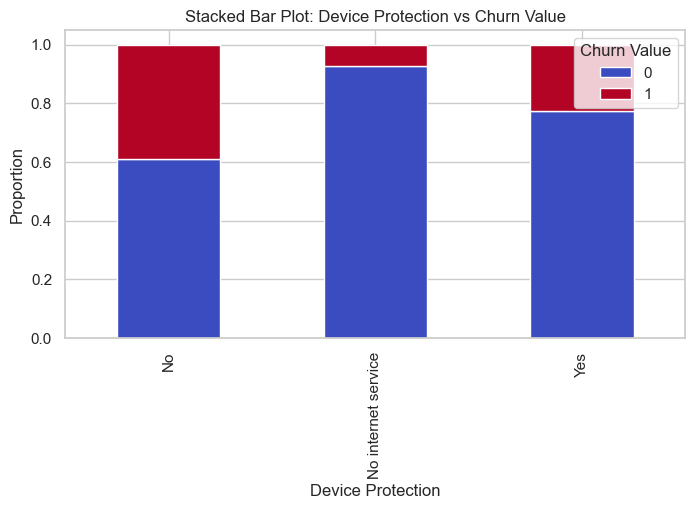

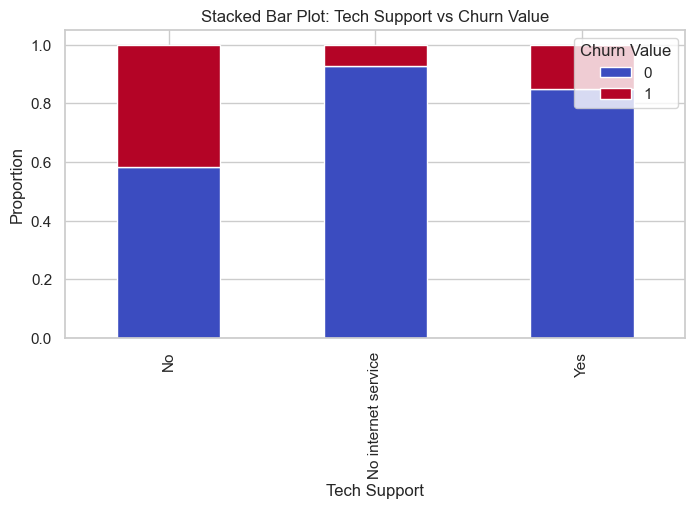

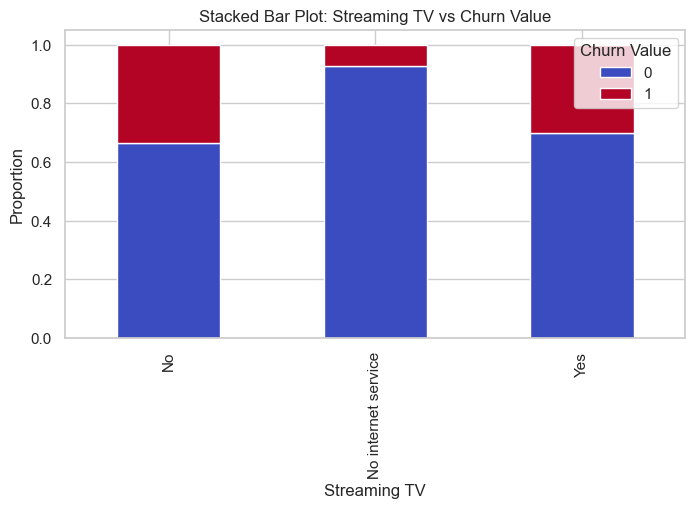

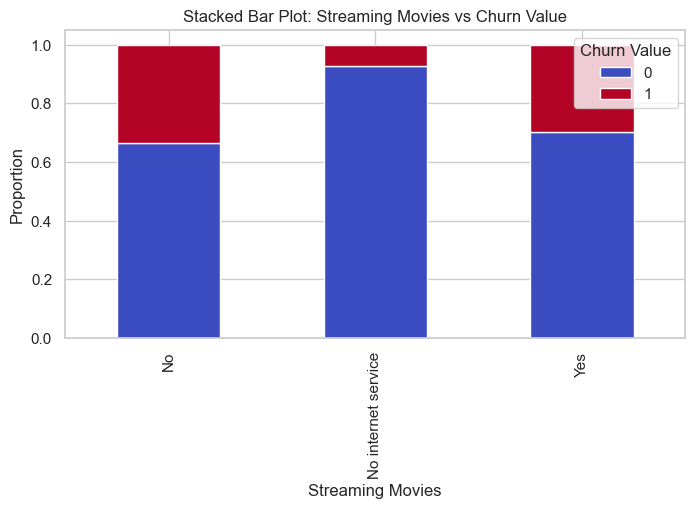

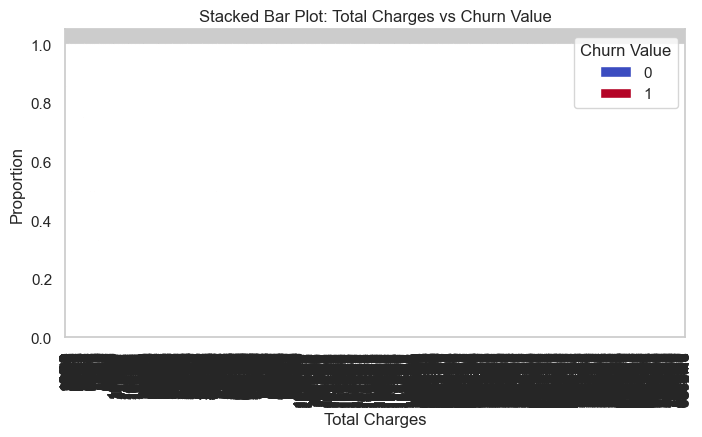

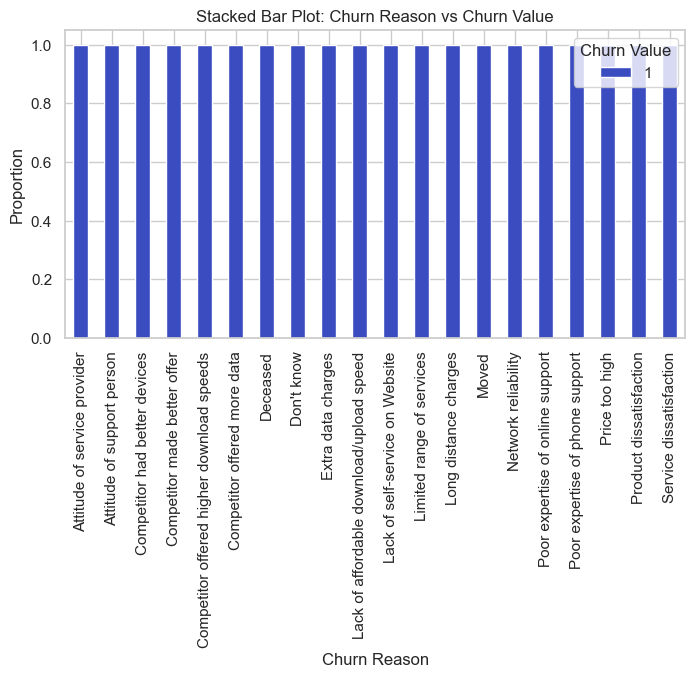

In [15]:
# Function to plot stacked bar charts
def plot_stacked_bar(column):
    # Create a contingency table
    crosstab = pd.crosstab(data[column], data['Churn Value'], normalize='index')

    # Plot the stacked bar chart
    crosstab.plot(kind='bar', stacked=True, figsize=(8, 4), colormap='coolwarm')
    plt.title(f'Stacked Bar Plot: {column} vs Churn Value')
    plt.xlabel(column)
    plt.ylabel('Proportion')
    plt.legend(title='Churn Value', loc='upper right')
    plt.show()

# Plot stacked bar charts for all categorical columns
for col in categorical_cols:
    plot_stacked_bar(col)

In [16]:
# Perform Chi-Square test for each categorical feature
for col in categorical_cols:
    crosstab = pd.crosstab(data[col], data['Churn Value'])
    chi2, p, dof, expected = chi2_contingency(crosstab)
    
    print(f'{col}: Chi2 = {chi2:.2f}, p = {p:.4f}')
    if p < 0.05:
        print(f"  -> Significant relationship with Churn (p < 0.05)\n")
    else:
        print(f"  -> No significant relationship with Churn (p >= 0.05)\n")

City: Chi2 = 1233.57, p = 0.0150
  -> Significant relationship with Churn (p < 0.05)

Lat Long: Chi2 = 1745.97, p = 0.0512
  -> No significant relationship with Churn (p >= 0.05)

Multiple Lines: Chi2 = 11.33, p = 0.0035
  -> Significant relationship with Churn (p < 0.05)

Online Security: Chi2 = 850.00, p = 0.0000
  -> Significant relationship with Churn (p < 0.05)

Online Backup: Chi2 = 601.81, p = 0.0000
  -> Significant relationship with Churn (p < 0.05)

Device Protection: Chi2 = 558.42, p = 0.0000
  -> Significant relationship with Churn (p < 0.05)

Tech Support: Chi2 = 828.20, p = 0.0000
  -> Significant relationship with Churn (p < 0.05)

Streaming TV: Chi2 = 374.20, p = 0.0000
  -> Significant relationship with Churn (p < 0.05)

Streaming Movies: Chi2 = 375.66, p = 0.0000
  -> Significant relationship with Churn (p < 0.05)

Total Charges: Chi2 = 6514.05, p = 0.5532
  -> No significant relationship with Churn (p >= 0.05)

Churn Reason: Chi2 = 0.00, p = 1.0000
  -> No significan

- Multiple Lines (keep it): Customers with multiple lines or no phone service churn at similar rates.Single line customers seem to churn less frequently. Significant relationship with Churn (p < 0.05)
- Internet Service (keep it): Fiber optic customers churn more than DSL customers. Customers with no internet service have minimal churn. Significant relationship with Churn (p < 0.05)
- Online Security & oline Backup  & Device Protection & Tech Support (testing for multicollinearity (correlation between these features) during feature selection because they could be redundant): CMore churn for customers without these services. Again, no internet service customers rarely churn. Significant relationship with Churn (p < 0.05)
- Streaming Movies & Streaming TV (testing for multicollinearity (correlation between these features) during feature selection because they could be redundant) : Observation: Both "Yes" and "No" categories have a similar churn proportion. Customers with no internet service have minimal churn. Significant relationship with Churn (p < 0.05)
- Lat Long (drop it): The Lat Long is highly fragmented with too many unique values, making it hard to derive meaningful patterns from these visualizations. No significant relationship with Churn (p >= 0.05)
- City (keep it): It has a significant relationship with Churn (p < 0.05)
- Total Charges (drop it): The Total Charges values are scattered across a wide range, with no clear pattern in the churn distribution. No significant relationship with Churn (p >= 0.05)
- Payment Method (keep it): Customers paying with Electronic Check show higher churn than those using Bank Transfer, Credit Card, or Mailed Check. Significant relationship with Churn (p < 0.05)
- Contract (keep it): Month-to-Month contracts have higher churn compared to One-Year and Two-Year contracts. One-Year and Two-Year contracts have very low churn rates. Significant relationship with Churn (p < 0.05)
- Churn Reason (drop it): It has a significant relationship with Churn (p < 0.05)

In [17]:
##Churn Reason, Lat Long
data.drop(['Churn Reason', 'Lat Long'], axis=1,inplace=True)

In [18]:
data.select_dtypes(include=['object', 'category']).columns

Index(['City', 'Multiple Lines', 'Online Security', 'Online Backup',
       'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',
       'Total Charges'],
      dtype='object')

In [19]:
##Multiple Lines
# Map Multiple Lines to 3 values
data['Multiple Lines'] = data['Multiple Lines'].map({'Yes':1, 'No':0, 'No phone service':0})

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   City                                    7043 non-null   object 
 1   Gender                                  7043 non-null   int64  
 2   Senior Citizen                          7043 non-null   int64  
 3   Partner                                 7043 non-null   int64  
 4   Dependents                              7043 non-null   int64  
 5   Tenure Months                           7043 non-null   int64  
 6   Phone Service                           7043 non-null   int64  
 7   Multiple Lines                          7043 non-null   int64  
 8   Online Security                         7043 non-null   object 
 9   Online Backup                           7043 non-null   object 
 10  Device Protection                       7043 non-null   obje

- City: I will Cluster Cities Using K-Means Based on Latitude and Longitude with K=5
- I will create a new variable called ((City Cluster)) and delet the old one (City)

Using Silhouette Score to find the optimal k for "City". The Silhouette Score measures how similar a point is to its own cluster compared to other clusters.

C:\Users\musta\anaconda3\envs\gpu\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\musta\anaconda3\envs\gpu\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\musta\anaconda3\envs\gpu\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\musta\anaconda3\envs\gpu\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\musta\anaco

C:\Users\musta\anaconda3\envs\gpu\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\musta\anaconda3\envs\gpu\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\musta\anaconda3\envs\gpu\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\musta\anaconda3\envs\gpu\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\musta\anaco

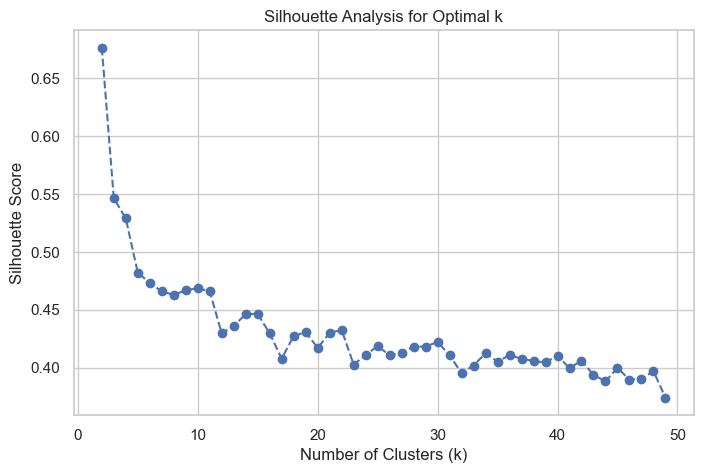

In [21]:
##City
# Select Latitude and Longitude columns for clustering
coordinates = data_city

# Use Silhouette Analysis to find the optimal k
silhouette_scores = []

# Calculate silhouette score for k values ranging from 2 to 15
for k in range(2, 50):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(coordinates)
    silhouette_avg = silhouette_score(coordinates, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plotting Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 50), silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.show()

#### Insights from the Plot:
- High Silhouette Score for Small k: The silhouette score is highest when k = 2. This means that when there are fewer clusters, the points are well-separated. However, only two clusters may be too simplistic for your data.
- Score Decrease Beyond k = 10: There is a noticeable drop in silhouette scores after k = 10. This might suggest that the quality of clustering diminishes beyond 10 clusters.
- Flattening Trend: Beyond approximately k = 15, the silhouette score seems to flatten out, with only slight changes. This flattening trend indicates that increasing the number of clusters does not lead to significantly better clustering quality.
#### Suggested Optimal Value for k:
- Based on the plot, k = 3 to 6 appears to be a good candidate for the number of clusters. This range provides a balance between having meaningful clusters and maintaining a relatively high silhouette score.
- k = 5 might be a reasonable choice, as it maintains a good silhouette score while allowing for more detailed clustering compared to k = 2.

In [22]:
Optimal_K_Value  = 5
# Perform K-means clustering with an arbitrary number of clusters (e.g., 5)
kmeans = KMeans(n_clusters= Optimal_K_Value, random_state= 42)
data['City Cluster'] = kmeans.fit_predict(coordinates)

# Drop city
data.drop(['City'], axis=1, inplace=True)

C:\Users\musta\anaconda3\envs\gpu\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [23]:
data['City Cluster'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 7043 entries, 0 to 7042
Series name: City Cluster
Non-Null Count  Dtype
--------------  -----
7043 non-null   int32
dtypes: int32(1)
memory usage: 27.6 KB


In [24]:
##Online Security & oline Backup & Device Protection & Tech Support
data['Online Security'].value_counts()

No                     3498
Yes                    2019
No internet service    1526
Name: Online Security, dtype: int64

                   Online Security  Online Backup  Device Protection  \
Online Security           1.000000       0.283832           0.275438   
Online Backup             0.283832       1.000000           0.303546   
Device Protection         0.275438       0.303546           1.000000   
Tech Support              0.354931       0.294233           0.333313   

                   Tech Support  
Online Security        0.354931  
Online Backup          0.294233  
Device Protection      0.333313  
Tech Support           1.000000  


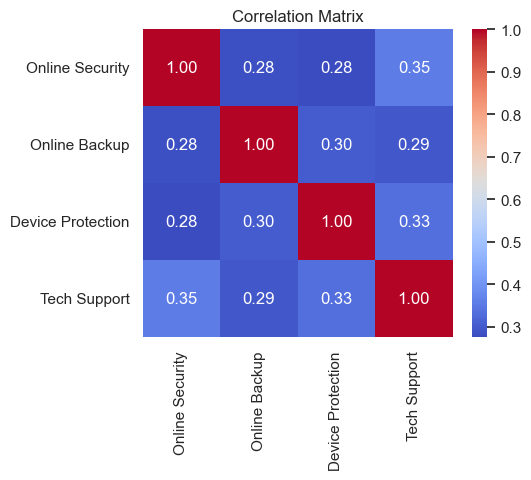

In [25]:
# Calculation of Confusion Matrix to see if there is any correlation between these variables

# Map Online Security & oline Backup & Device Protection & Tech Support to 3 values
data['Online Security'] = data['Online Security'].map({'Yes':1, 'No':0, 'No internet service':0})
data['Online Backup'] = data['Online Backup'].map({'Yes':1, 'No':0, 'No internet service':0})
data['Device Protection'] = data['Device Protection'].map({'Yes':1, 'No':0, 'No internet service':0})
data['Tech Support'] = data['Tech Support'].map({'Yes':1, 'No':0, 'No internet service':0})

# Compute the correlation matrix
correlation_matrix = data[['Online Security', 'Online Backup','Device Protection','Tech Support']].corr()

# Display the matrix
print(correlation_matrix)

# Optional: Plot the heatmap for better visualization
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [26]:
# Calculation of Variance Inflation Factor to see if there is any correlation between these variables (Methos statistic)

# Select relevant features
X = data[['Online Security', 'Online Backup','Device Protection','Tech Support']]

# Add a constant (intercept) to the features
X = sm.add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


             Feature       VIF
0              const  1.979915
1    Online Security  1.215649
2      Online Backup  1.188015
3  Device Protection  1.210034
4       Tech Support  1.261712


- Based on Confusion Matrix; we got a Moderate Correlation (~0.5 - 0.8): Some overlap, but both may still add value.
- Based on VIF (Variance Inflation Factor); all the variables their VIF between 1 < VIF < 5 and thwy consider as a Moderate correlation so they don't have a strong corelation.
- Decision: i will keep all of them

In [27]:
##Streaming Movies & Streaming TV
data['Streaming Movies'].value_counts()

No                     2785
Yes                    2732
No internet service    1526
Name: Streaming Movies, dtype: int64

                  Streaming Movies  Streaming TV
Streaming Movies          1.000000      0.533094
Streaming TV              0.533094      1.000000


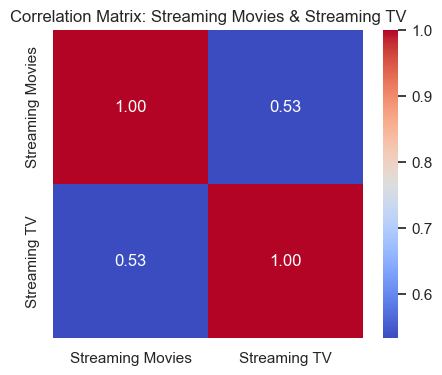

In [28]:
# Map Streaming Movies and Streaming TV to 3 values
data['Streaming Movies'] = data['Streaming Movies'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
data['Streaming TV'] = data['Streaming TV'].map({'Yes': 1, 'No': 0, 'No internet service': 0})

# Compute the correlation matrix
correlation_matrix = data[['Streaming Movies', 'Streaming TV']].corr()

# Display the matrix
print(correlation_matrix)

# Optional: Plot the heatmap for better visualization

plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix: Streaming Movies & Streaming TV')
plt.show()

High Correlation (> 0.8): Indicates multicollinearity. Both features contain redundant information, and you may want to drop one of them.
- I will drop (('Streaming Movies'))

In [29]:
data.drop('Streaming Movies', axis=1, inplace=True)


# Step 6: Exploratory Data Analysis - Target Variable

In this step, we visualize the distribution of the target variable (`Churn Value`) to understand the class balance, which is crucial for model evaluation.


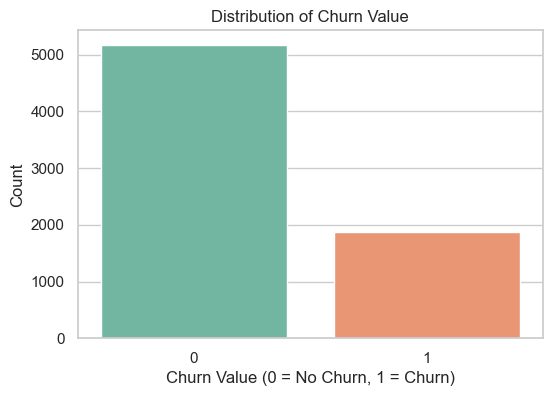

In [30]:
# Visualizing the distribution of the target variable 'Churn Value' to understand the class balance.
# Understanding class distribution is important for choosing the right evaluation metric and handling class imbalance, if necessary.

plt.figure(figsize=(6, 4))
sns.countplot(x='Churn Value', data=data, palette='Set2')
plt.title('Distribution of Churn Value')
plt.xlabel('Churn Value (0 = No Churn, 1 = Churn)')
plt.ylabel('Count')
plt.show()

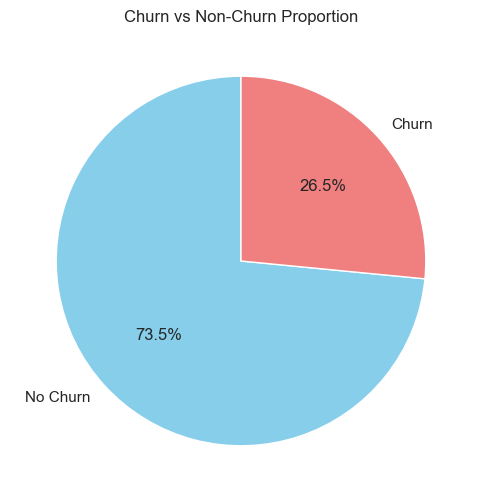

In [31]:
# Calculate the proportion of Churn vs Non-Churn
churn_counts = data['Churn Value'].value_counts()

# Plot the pie chart
plt.figure(figsize=(6, 6))
plt.pie(churn_counts, labels=['No Churn', 'Churn'], autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('Churn vs Non-Churn Proportion')
plt.show()


In [32]:
# Get a summary of the target variable
churn_stats = data['Churn Value'].describe()

print("Statistics for Churn Value:")
print(churn_stats)

Statistics for Churn Value:
count    7043.000000
mean        0.265370
std         0.441561
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Churn Value, dtype: float64


- 26.5370 % in the churn rate is means that about 1 in 4 customers in the dataset has churned.
- While not perfectly balanced, the churn rate is within a reasonable range (~25-30%), because most standard machine learning algorithms like Logistic Regression, Random Forest ect, can handle this case.
- If the churn rate low than 20%, then we have to use Smote or other method to make it balanced.
- std = 0.441561 close to 0.5 indicates that the classes are mostly balanced.

 ---> I will Introduce Smote methode to balance the dataset

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Gender                                  7043 non-null   int64  
 1   Senior Citizen                          7043 non-null   int64  
 2   Partner                                 7043 non-null   int64  
 3   Dependents                              7043 non-null   int64  
 4   Tenure Months                           7043 non-null   int64  
 5   Phone Service                           7043 non-null   int64  
 6   Multiple Lines                          7043 non-null   int64  
 7   Online Security                         7043 non-null   int64  
 8   Online Backup                           7043 non-null   int64  
 9   Device Protection                       7043 non-null   int64  
 10  Tech Support                            7043 non-null   int6

In [34]:
## replacing blank strings with NULL in `Total Charges` and transform it to integer
data['Total Charges'] = data['Total Charges'].apply(lambda x: np.nan if type(x) == str else x)
## confirming NULL values in `Total Charges`
data['Total Charges'].isna().sum()

data = data.dropna()
data['Total Charges'] = data['Total Charges'].astype(float)

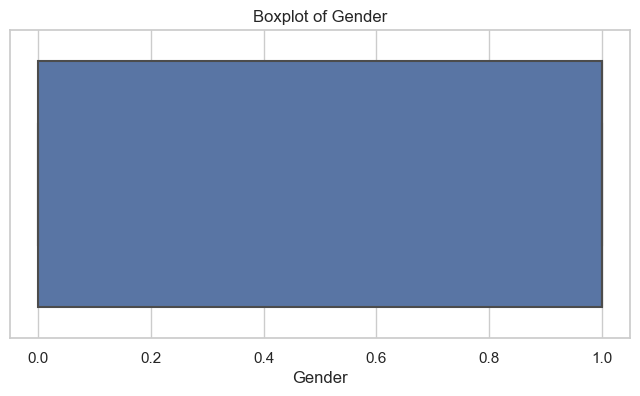

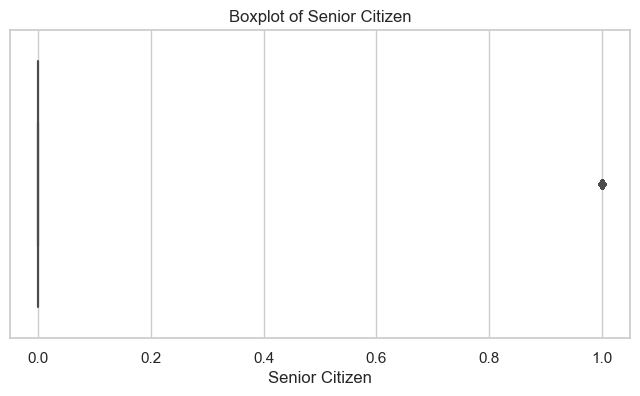

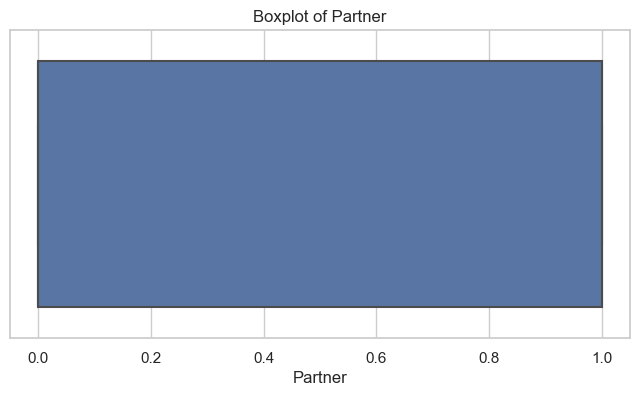

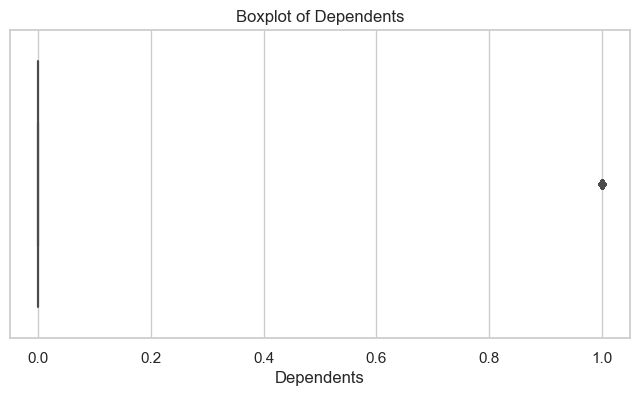

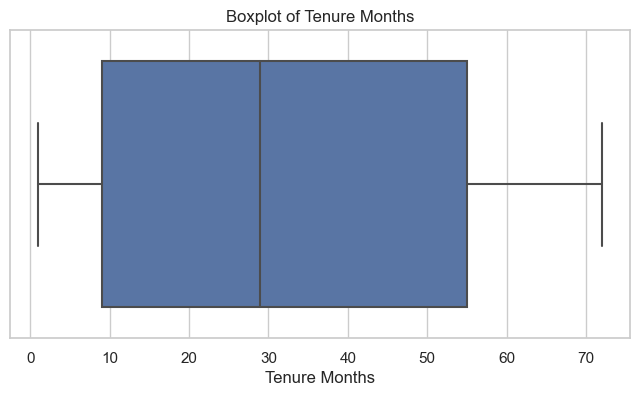

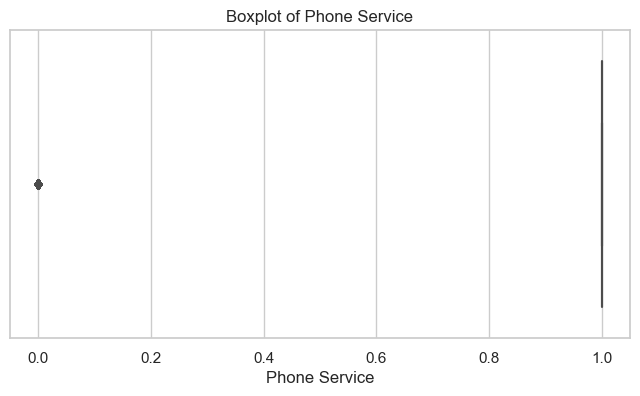

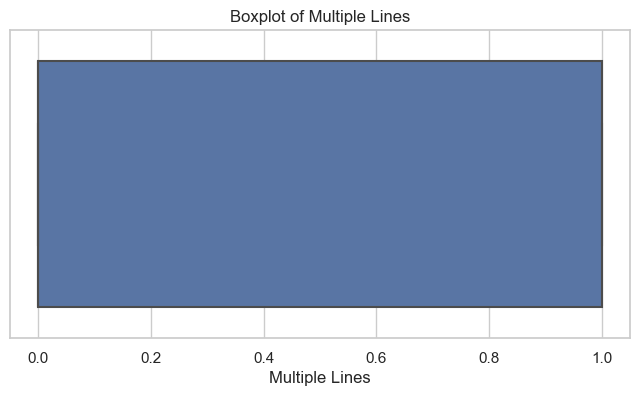

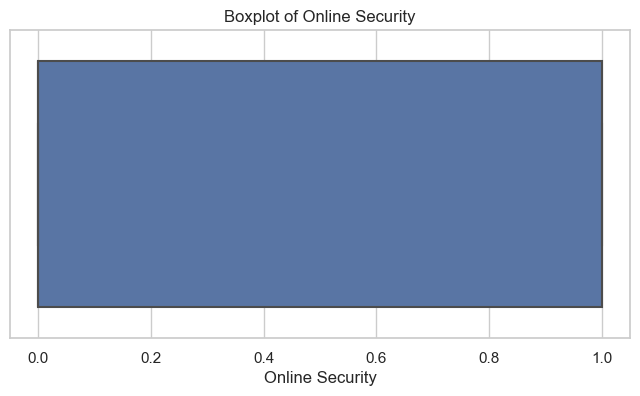

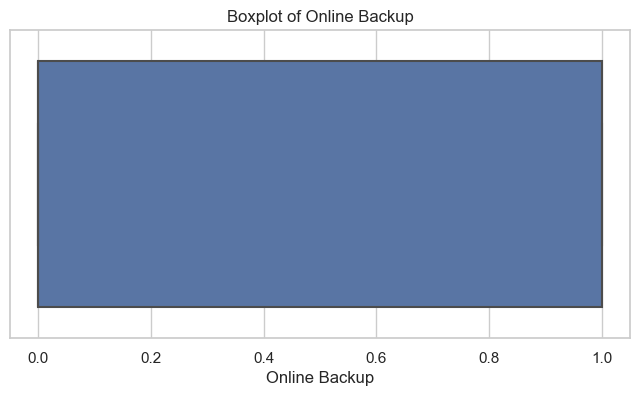

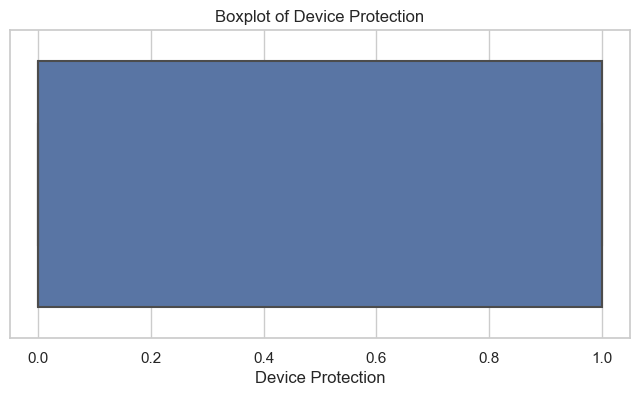

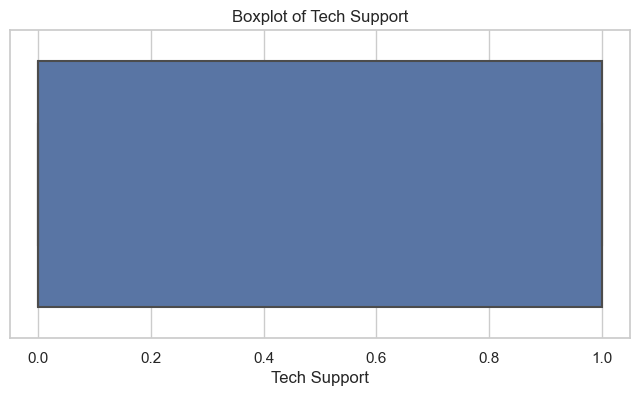

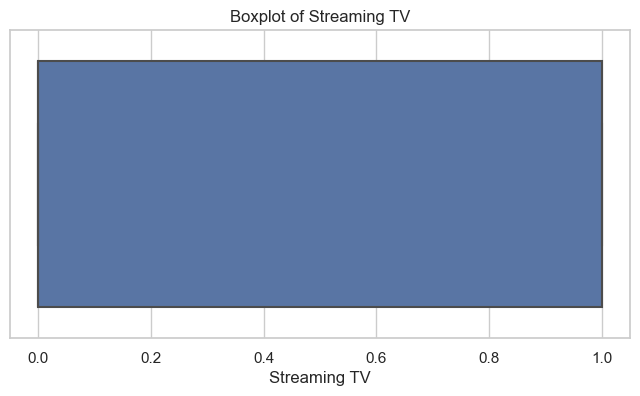

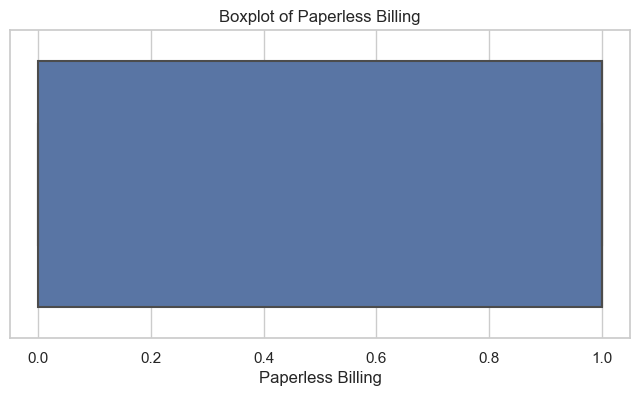

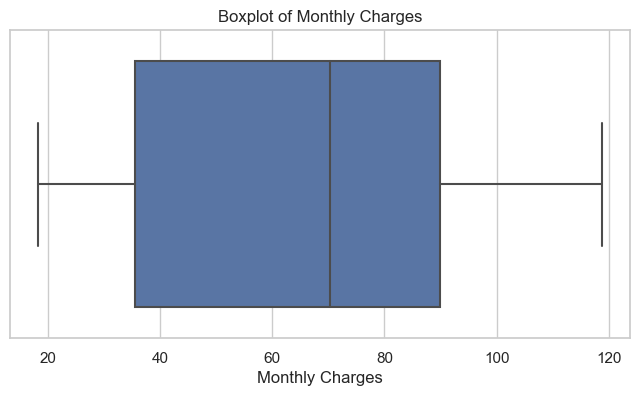

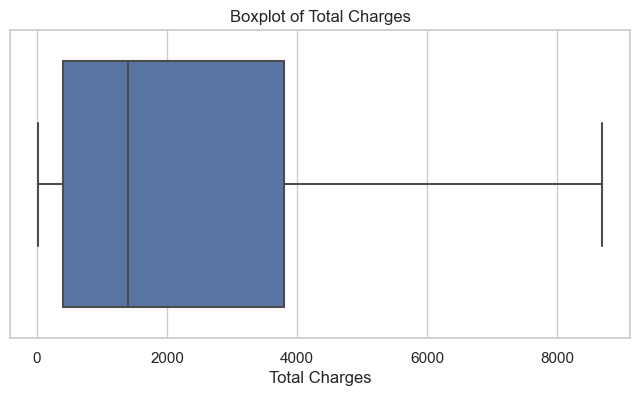

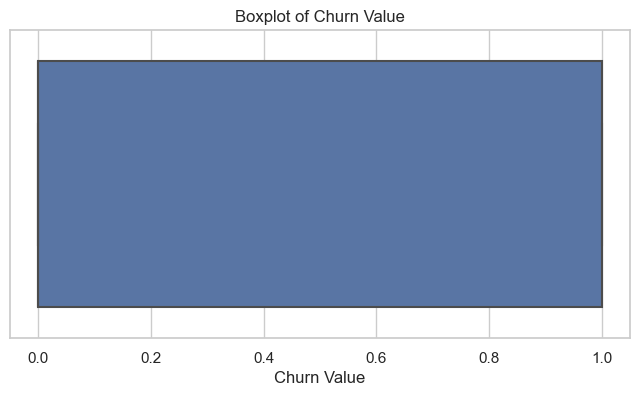

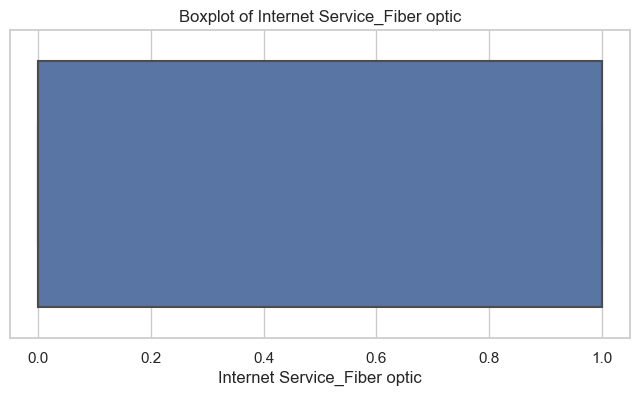

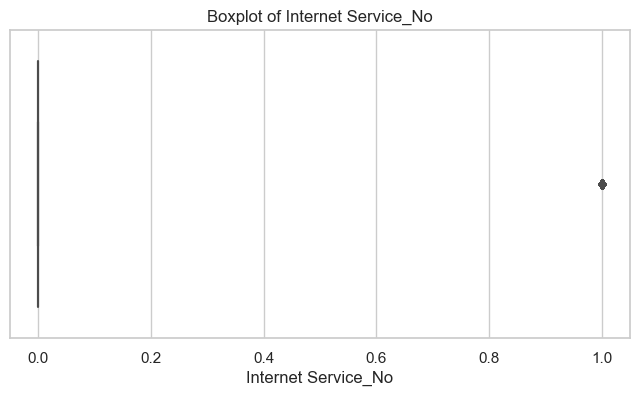

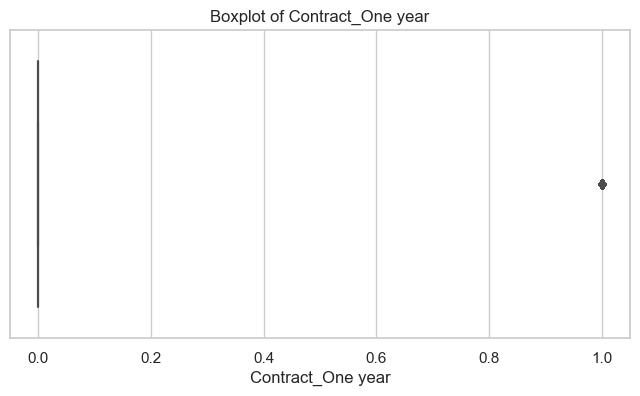

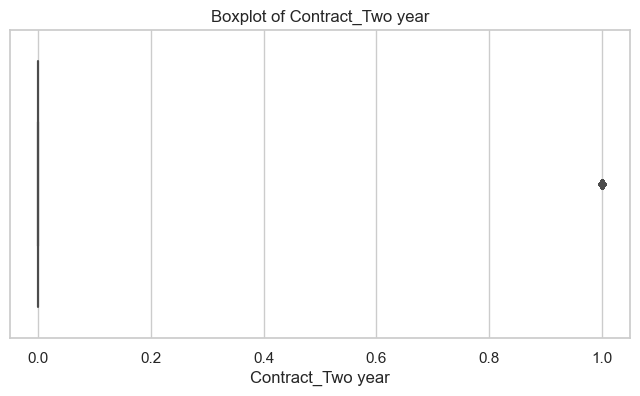

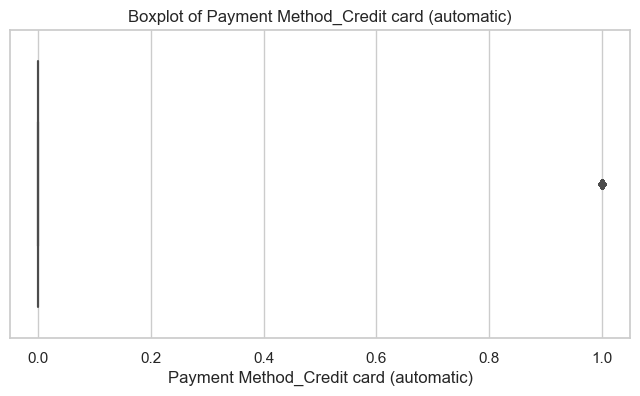

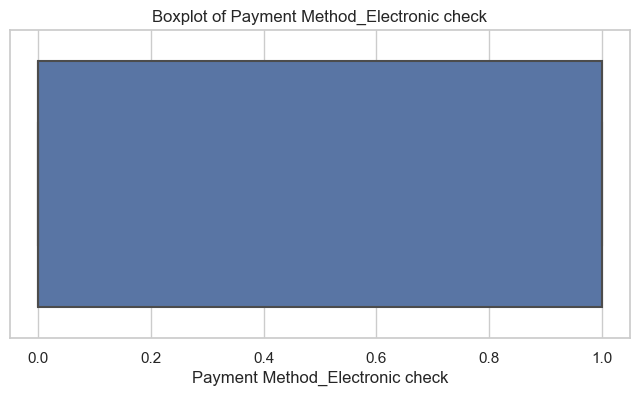

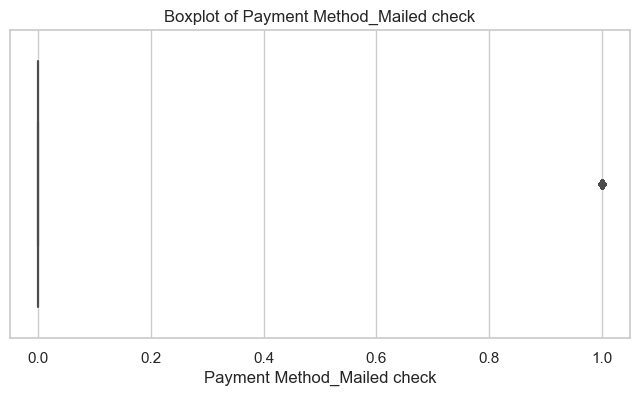

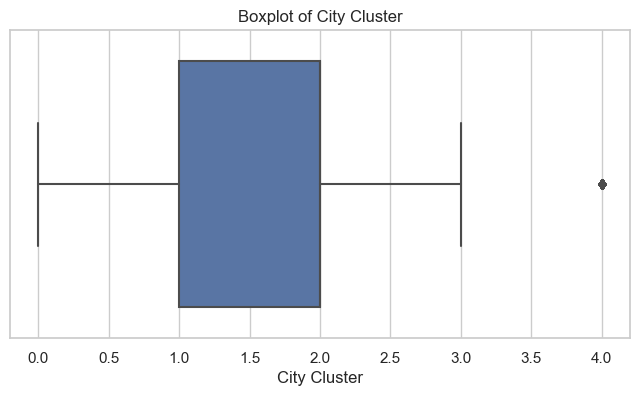

In [35]:
#Cheking for Outliers:
# Create boxplots for each numerical feature
for feature in data.columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[feature])
    plt.title(f'Boxplot of {feature}')
    plt.show()

Based on the box plots, we do not have any outliers in the dataset, although some features showed some outliers and after re-examining them, they turned out to be non-outliers.

In [36]:
## fetching duplicated rows (as a whole) in the dataframe
data.duplicated().sum()

4

In [37]:
# Fetch the duplicated rows
duplicated_rows = data[data.duplicated()]

# Display duplicated rows
print(duplicated_rows)

      Gender  Senior Citizen  Partner  Dependents  Tenure Months  \
3296       1               0        0           0              1   
5925       1               0        0           0              1   
6087       1               0        0           0              1   
6854       0               0        0           0              1   

      Phone Service  Multiple Lines  Online Security  Online Backup  \
3296              1               0                0              0   
5925              1               0                0              0   
6087              1               0                0              0   
6854              1               0                0              0   

      Device Protection  ...  Total Charges  Churn Value  \
3296                  0  ...          20.20            0   
5925                  0  ...          20.20            0   
6087                  0  ...          20.05            0   
6854                  0  ...          19.65            0   

  

In [38]:
# Remove duplicated rows, keeping the first occurrence
data = data.drop_duplicates()


# Step 7:  Applying SMOTE and Splitting the Dataset

- Resampling the dataset using SMOTE oversampling
- We split the data into training and testing sets, typically with an 80/20 split, to evaluate the model's ability to generalize to unseen data.


In [39]:
# We split the data into training and testing sets to evaluate our model's performance on unseen data.
# 80% of the data is used for training, while 20% is held back for testing.
# This helps in assessing the model's generalization capability.

# Define the features (X) and target (y)
X = data.drop(['Churn Value'], axis=1)  # Drop target column from features
y = data['Churn Value']  # Define the target


## creating an instance of SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(k_neighbors=5, random_state=101, sampling_strategy=1)
## resampling the dataset using SMOTE oversampling
X, y = smote.fit_resample(X, y)


# Split the data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the datasets
print(f"Train Set: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test Set: X_test={X_test.shape}, y_test={y_test.shape}")

Train Set: X_train=(8254, 23), y_train=(8254,)
Test Set: X_test=(2064, 23), y_test=(2064,)



# Step 8: Feature Scaling

Scaling the features ensures that they are on the same scale, which is particularly important for algorithms like SVM, K-Nearest Neighbors, and others sensitive to feature magnitude.


In [40]:
# Many machine learning algorithms, such as Logistic Regression and SVM, benefit from scaled features.
# Here we use StandardScaler to standardize features by removing the mean and scaling to unit variance.

scaler = StandardScaler()
# Fit and transform the training data, and transform the test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Step 9: Model Training and Evaluation

We will train a Random Forest model to predict customer churn. The performance of the model will be evaluated using metrics such as accuracy, precision, recall, and F1-score.

In [41]:
def create_models(seed=42):
    '''
    Create a list of machine learning models.
            Parameters:
                    seed (integer): random seed of the models
            Returns:
                    models (list): list containing the models
    '''
    models = []
    
    # Add various models
    models.append(('logistic_regression', LogisticRegression(random_state=seed)))
    models.append(('support_vector_machines', SVC(random_state=seed)))
    models.append(('random_forest', RandomForestClassifier(random_state=seed)))
    models.append(('gradient_boosting', GradientBoostingClassifier(random_state=seed)))
    models.append(('k_nearest_neighbors', KNeighborsClassifier()))
    models.append(('naive_bayes', GaussianNB()))
    models.append(('xgboost', XGBClassifier(random_state=seed, use_label_encoder=False, eval_metric='logloss')))
    models.append(('lightgbm', LGBMClassifier()))
    
    return models

# Create a list with all the algorithms we are going to assess
models = create_models()

# Test the accuracy of each model using cross-validation
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    # Perform cross-validation
    score = cross_val_score(model, X_train_scaled, y_train, cv=10, scoring=scoring)
    results.append(score)
    names.append(name)
    # Print classifier accuracy (mean) and standard deviation
    print(f'Classifier: {name}, Accuracy: {score.mean():.4f}, Std: {score.std():.4f}')

C:\Users\musta\anaconda3\envs\gpu\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Classifier: logistic_regression, Accuracy: 0.8398, Std: 0.0104
Classifier: support_vector_machines, Accuracy: 0.8415, Std: 0.0132
Classifier: random_forest, Accuracy: 0.8504, Std: 0.0115
Classifier: gradient_boosting, Accuracy: 0.8448, Std: 0.0136
Classifier: k_nearest_neighbors, Accuracy: 0.8211, Std: 0.0124
Classifier: naive_bayes, Accuracy: 0.8161, Std: 0.0118


C:\Users\musta\anaconda3\envs\gpu\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\musta\anaconda3\envs\gpu\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\musta\anaconda3\envs\gpu\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\musta\anaconda3\envs\gpu\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\musta\anaconda3\envs\gpu\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\musta\

Classifier: xgboost, Accuracy: 0.8483, Std: 0.0102
[LightGBM] [Info] Number of positive: 3704, number of negative: 3724
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 646
[LightGBM] [Info] Number of data points in the train set: 7428, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498654 -> initscore=-0.005385
[LightGBM] [Info] Start training from score -0.005385
[LightGBM] [Info] Number of positive: 3704, number of negative: 3724
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 646
[LightGBM] [Info] Number of data points in the train set: 7428, num

# Step 10: Fine Tuning (Hyperparameter Tuning: RandomSearchCV)


In [42]:
## defining a function to print classification report and plot the confusion matrix
def modelPerformance(model, test, result):
    y_pred = model.predict(test)
    print(classification_report(result, y_pred))
    print('Accuracy - ',accuracy_score(result, y_pred))
    print('Recal - ',recall_score(result, y_pred))
    print('Precision - ',precision_score(result, y_pred))
    print('F1-Score - ',f1_score(result, y_pred))

#### RandomForestClassifier

In [43]:
## setting up the hyperparameters for RandomForestClassifier
paramsRF = {
    "n_estimators": np.linspace(64, 256, 10, dtype = int),
    "criterion": ['gini', 'log_loss'],
    "max_depth": [6, 8, None],
    "max_features": ['sqrt', 'log2', None]
}
## creating the RandomizedSearchCV object
randomRF = RandomizedSearchCV(RandomForestClassifier(random_state=101), paramsRF, n_jobs=4, verbose=1, cv=5, scoring='f1', refit=True)
## fiting the RandomizedSearchCV model to find the best parameters for Random Forest
randomRF.fit(X_train_scaled, y_train)
## fetching the best parameters four
randomRF.best_params_

    
## evaluating the result on validation set
modelPerformance(randomRF, X_test_scaled, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1021
           1       0.85      0.85      0.85      1043

    accuracy                           0.85      2064
   macro avg       0.85      0.85      0.85      2064
weighted avg       0.85      0.85      0.85      2064

Accuracy -  0.8478682170542635
Recal-  0.8465963566634708
Precisio -  0.8514946962391514
F1-Score -  0.8490384615384615


####  SVM

In [44]:
## setting up the hyperparameters for SVC
paramsSVC = {
    'kernel': ['linear', 'rbf'], 
    'C': [0.1, 1, 10],
    'gamma': ['auto', 'scale']
}
## creating a RandomizedSearchCV object for SVC
randomSVC = RandomizedSearchCV(SVC(random_state=101, max_iter=-1, probability=True), paramsSVC, n_jobs=4, verbose=1, cv=5, scoring = 'f1', refit=True)
## fiting the RandomizedSearchCV model to find the best parameters for Random Forest
randomSVC.fit(X_train_scaled, y_train)
best_randomSVC_model = randomSVC.best_estimator_
    
## evaluating the result on validation set
modelPerformance(best_randomSVC_model, X_test_scaled, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1021
           1       0.83      0.85      0.84      1043

    accuracy                           0.84      2064
   macro avg       0.84      0.84      0.84      2064
weighted avg       0.84      0.84      0.84      2064

Accuracy -  0.8381782945736435
Recal-  0.8533077660594439
Precisio -  0.830999066293184
F1-Score -  0.8420056764427625


#### XGBoostClassifier 

In [45]:
## setting the hyperparameters for XGBoost 
paramsXG = {
    "n_estimators": np.linspace(64, 256, 10, dtype = int),
    "eta": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [6, 8, None],
    "subsample": [0.5, 0.8, 1.0]    
}

## creating the RandomizedSearchCV object for XGBoostClassifier
randomXGB = RandomizedSearchCV(XGBClassifier(seed=101, eval_metric='logloss', objective='binary:logistic'), paramsXG, n_jobs=4, verbose=1, cv=5, scoring='f1', refit=True)
## fiting the model
randomXGB.fit(X_train_scaled, y_train)
best_randomXGB_model = randomXGB.best_estimator_
    
## evaluating the result on validation set
modelPerformance(best_randomXGB_model, X_test_scaled, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1021
           1       0.84      0.85      0.85      1043

    accuracy                           0.85      2064
   macro avg       0.85      0.85      0.85      2064
weighted avg       0.85      0.85      0.85      2064

Accuracy -  0.8454457364341085
Recal-  0.8523489932885906
Precisio -  0.8434535104364327
F1-Score -  0.8478779208392943


### LGBMClassifier

In [46]:
# Define the parameter grid
param_grid = {
    'num_leaves': [20, 30, 40, 50],
    'max_depth': [10, 15, 20, 25],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'n_estimators': [100, 200, 300, 400],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

# Initialize the LGBMClassifier
lgbm_model = LGBMClassifier()

# Initialize RandomizedSearchCV
randomlgbm = RandomizedSearchCV(estimator=lgbm_model, 
                                   param_distributions=param_grid, 
                                   n_iter=20, # Number of parameter settings that are sampled
                                   cv=5,      # 5-fold cross-validation
                                   verbose=1, # To show the progress of the search
                                   random_state=42,
                                   n_jobs=-1) # Use all processors

# Fit the model
randomlgbm.fit(X_train_scaled, y_train)
best_lgbm_model = randomlgbm.best_estimator_

## evaluating the result on validation set
modelPerformance(best_lgbm_model, X_test_scaled, y_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Number of positive: 4116, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 646
[LightGBM] [Info] Number of data points in the train set: 8254, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498667 -> initscore=-0.005331
[LightGBM] [Info] Start training from score -0.005331
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1021
           1       0.84      0.86      0.85      1043

    accuracy                           0.84      2064
   macro avg       0.85      0.84      0.84      2064
weighted avg       0.85      0.84      0.84      2064

Accuracy -  0.8449612403100775
Recal-  0.8571428571428571

## Model Interpretation 

In our decision-making process for Churn Prediction models, we chose to use LGBMClassifier, because it provides better metrics than other classifiers.
- Accuracy -  0.8449612403100775
- Recal-  0.8571428571428571
- Precision -  0.8394366197183099
- F1-Score -  0.8481973434535105


# Step 11: Feature Importance Analysis

Analyzing the feature importance helps us understand which features contribute the most to predicting churn, which can provide valuable business insights.


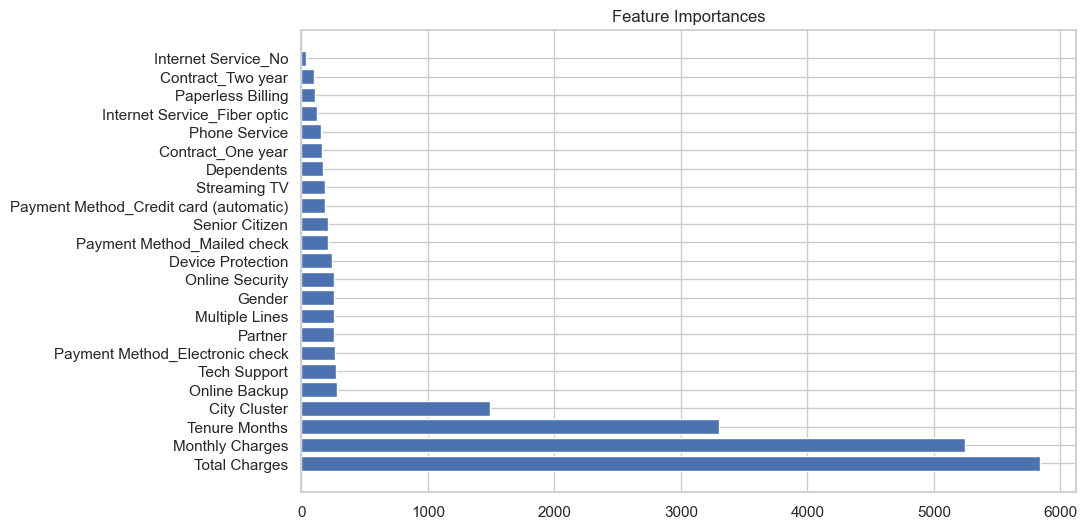

In [50]:
# Feature Importance Analysis
# Analyzing feature importances to understand which features contribute most to the prediction of churn.

# Get the best estimator (the final trained model)
best_model = randomlgbm.best_estimator_

# Get feature importances from the best model
feature_importances = best_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.title('Feature Importances')
plt.show()


 Based on the plot, it looks like the most important features are:

- Total Charges: This has the highest importance, indicating that it plays a significant role in predicting churn.
- Monthly Charges: Also a very important feature.
- Tenure Months: The length of time a customer has been with the company is a strong indicator of churn likelihood.
- City Cluster: It also appears to have a moderate impact.
- Other features like Internet Service, Payment Method, and Contract have much smaller impacts.


# Step 12: Saving the Model

The trained model is saved to disk using joblib. This allows us to reuse the model for predictions without retraining, which is efficient for deployment.


In [48]:
# Saving the trained model using joblib for future use.
# This allows us to easily deploy or re-use the model without retraining it from scratch.

# Save the model
joblib.dump(best_model, 'lgbm_churn_model.pkl')

# To load the model later
#loaded_model = joblib.load('lgbm_churn_model.pkl')

# Step 13: Deploy the Model

See 'web site' file